In [105]:
import pymc3 as pm
import arviz as az
import pandas as pd
import numpy as np
from scipy import stats
import theano
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt

In [106]:
def standardize(x):
    return (x-np.mean(x)) / np.std(x)

### Four elemental confounds 

1. The Fork:
X <- Z -> Y

2. The Pipe:
X -> Z -> Y

3. The Collider:
X -> Z <- Y

4. The Descendent
X -> Z <- Y | 
Z -> D




### 6M1
Modify the DAG on page 186 to include the variable V, an unobserved cause of C and Y:
C ← V → Y. Reanalyze the DAG. How many paths connect X to Y? Which must be closed? Which
variables should you condition on now?

In [107]:
## original DAG
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B")
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'A'})
frozenset({'C'})


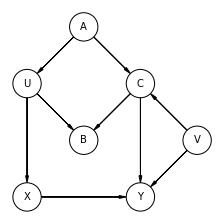

In [108]:
## modified DAG
dag_6_1m = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A", "V"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
        ("V", "C"),
        ("V", "Y")
    ],
)

pgm = daft.PGM()
coordinates = {"U": (0,1), "X": (0,3), "A": (1, 0), "B": (1, 2), "C": (2, 1), "Y": (2,3), "V": (3,2)}
for node in dag_6_1m.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_6_1m.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [109]:
# what do we need to condition on
all_adjustment_sets = dag_6_1m.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s): #jenom ty, ktere nejsou sebsets dalsich path
        if s != {"U"}:
            if s != {"V"}:
                print(s)

frozenset({'A'})
frozenset({'V', 'C'})


We must condition on A and C (to account for the effect of unobserved V)

### 6M2
Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among
predictors before including them in a model. This is a bad procedure, because what matters is the
conditional association, not the association before the variables are included in the model. To high-
light this, consider the DAG X → Z → Y. Simulate data from this DAG so that the correlation
between X and Z is very large. Then include both in a model prediction Y. Do you observe any
multicollinearity? Why or why not? What is different from the legs example in the chapter?

In [110]:
N = 100
X = stats.norm.rvs(size = N)
Z = stats.norm.rvs(loc = X, scale = 0.5)
Y = stats.norm.rvs(loc = Z)

df_m62 = pd.DataFrame({"X":X, "Z":Z})
print(df_m62.corr())

# Y = a + bx*X + bz*Z
with pm.Model() as m6_2:
    a = pm.Normal("a", 0, 1)
    bx = pm.Normal("bx", 0, 1)
    bz = pm.Normal("bz", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bx * X + bz * Z
    y = pm.Normal("y", mu, sigma, observed = Y)
    m6_2_trace = pm.sample(tune = 2000, draws = 2000)

az.summary(m6_2_trace)

          X         Z
X  1.000000  0.888921
Z  0.888921  1.000000
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.325,0.096,-0.508,-0.152,0.001,0.001,6346.0,5455.0,6351.0,4790.0,1.0
bx,0.081,0.203,-0.299,0.467,0.003,0.002,4307.0,3811.0,4267.0,4442.0,1.0
bz,0.898,0.172,0.574,1.212,0.003,0.002,4136.0,4086.0,4142.0,4757.0,1.0
sigma,0.946,0.069,0.822,1.075,0.001,0.001,6235.0,6235.0,6119.0,4062.0,1.0


bz je signifikantni protoze obsahuje informaci z X. Tedy pokud je X konstantni, Z nam stale rekne neco o Y 

In [111]:
N = 100
height = stats.norm.rvs(size = N, loc = 175, scale = 20)
leg_prop = stats.uniform.rvs(loc = 0.4, scale = 0.1, size=N) # simulate proportions
left_leg = leg_prop * height + stats.norm.rvs(size = N, loc=0, scale=1)
right_leg = leg_prop * height + stats.norm.rvs(size = N, loc=0, scale=1)

df_m62b = pd.DataFrame({"Left Leg":left_leg, "Right Leg":right_leg})
print(df_m62b.corr())

# Y = a + bx*X + bz*Z
with pm.Model() as m6_2b:
    a = pm.Normal("a", 0, 1)
    bl = pm.Normal("bl", 0, 1)
    br = pm.Normal("br", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bl * left_leg + br * right_leg
    H = pm.Normal("H", mu, sigma, observed = height)
    m6_2b_trace = pm.sample(tune=2000, draws=2000)

az.summary(m6_2b_trace)

           Left Leg  Right Leg
Left Leg   1.000000   0.990299
Right Leg  0.990299   1.000000
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, br, bl, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8868018259381297, but should be close to 0.8. Try to increase the number of tuning steps.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.631,1.014,-1.265,2.571,0.015,0.012,4319.0,3558.0,4320.0,3704.0,1.0
bl,0.960,0.512,-0.026,1.892,0.009,0.006,3188.0,3188.0,3202.0,3351.0,1.0
br,1.239,0.512,0.295,2.210,0.009,0.007,3185.0,2930.0,3200.0,3319.0,1.0
sigma,11.364,0.712,10.148,12.692,0.013,0.010,2785.0,2785.0,2601.0,2083.0,1.0


The DAG for this relationship looks like this:

L <- LP -> R | LP -> H

**Model foxes:**

A -> AF -> W | AF -> GS -> W

Use a model to infer the total causal influence of area on weight . Would increasing the area
available to each fox make it heavier (healthier)? You might want to standardize the variables. Re-
gardless, use prior predictive simulation to show that your model’s prior predictions stay within the
possible outcome range.

In [112]:
foxes = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv", sep = ";")
foxes.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [113]:
foxes_dag = CausalGraphicalModel(nodes=["A", "AF", "W", "GS"], 
                                edges=[
                                    ("A", "AF"),
                                    ("AF", "W"),
                                    ("AF", "GS"),
                                    ("GS", "W")
                                ])
print(foxes_dag.get_all_independence_relationships())
# area and weight are independent if we condition in averagefood. 

[('GS', 'A', {'AF'}), ('GS', 'A', {'AF', 'W'}), ('A', 'W', {'AF'}), ('A', 'W', {'GS', 'AF'})]


In [114]:
foxes_sd = foxes.apply(lambda x: standardize(x))
foxes_sd.describe()

,group,avgfood,groupsize,area,weight
count,1.160000e+02,1.160000e+02,1.160000e+02,1.160000e+02,1.160000e+02
mean,-4.594026e-17,3.100968e-16,-1.780185e-16,-5.933951e-16,4.153765e-16
std,1.004338e+00,1.004338e+00,1.004338e+00,1.004338e+00,1.004338e+00
min,-2.033956e+00,-1.933180e+00,-1.530701e+00,-2.249313e+00,-2.213621e+00
25%,-6.848372e-01,-4.645220e-01,-8.779020e-01,-6.265396e-01,-6.867840e-01
50%,9.953400e-02,-8.469668e-02,-2.251031e-01,-4.234132e-02,-9.301419e-02
75%,8.525303e-01,2.444853e-01,4.276958e-01,6.527464e-01,7.170575e-01
max,1.605527e+00,2.320864e+00,2.386093e+00,2.056445e+00,2.561985e+00


In [115]:
foxes_sd.corr()

,group,avgfood,groupsize,area,weight
group,1.000000,0.340845,0.400959,0.377773,-0.151900
avgfood,0.340845,1.000000,0.901483,0.883104,-0.025039
groupsize,0.400959,0.901483,1.000000,0.827594,-0.160994
area,0.377773,0.883104,0.827594,1.000000,0.019477
weight,-0.151900,-0.025039,-0.160994,0.019477,1.000000


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAF, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAF, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bAF,0.221,0.059,0.121,0.334,0.001,0.001,4017.0,3723.0,4091.0,2615.0,1.0
a,-0.001,0.097,-0.193,0.171,0.001,0.002,4683.0,2048.0,4680.0,2788.0,1.0
sigma,1.041,0.072,0.911,1.183,0.001,0.001,4994.0,4931.0,5039.0,2798.0,1.0


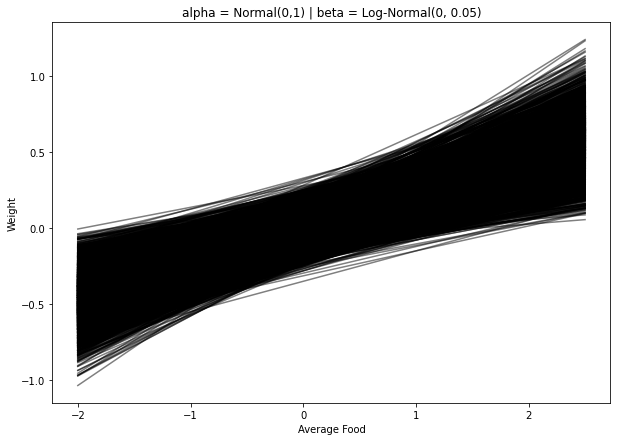

In [116]:
AF = theano.shared(foxes_sd.avgfood.values)

with pm.Model() as h6_3_af:
    a = pm.Normal("a", 0, 1)
    bAF = pm.Lognormal("bAF", 0, 0.5)
    mu = pm.Deterministic("mu", a + bAF * AF)
    sigma = pm.Exponential("sigma", 1)
    W = pm.Normal("W", mu, sigma, observed = foxes_sd.weight)
    h6_3_af_trace = pm.sample()

#set x from -2 to 2.5 for predictive simulation
xseq = [-2,2.5]
AF.set_value(xseq)
with h6_3_af:
    h6_3_af_prior_pred = pm.sample_posterior_predictive(h6_3_af_trace, var_names=["mu"])

#set back 
AF.set_value(foxes_sd.avgfood.values)
with h6_3_af:
        h6_3_af_trace = pm.sample()
#plot prior predictiove check
fig, ax = plt.subplots(figsize = (10,7))

for i in range(h6_3_af_prior_pred["mu"].shape[0]):
    ax.plot(xseq, h6_3_af_prior_pred["mu"][i], alpha = 0.5, color = "black")
    ax.set_xlabel("Average Food")
    ax.set_ylabel("Weight")
    ax.set_title("alpha = Normal(0,1) | beta = Log-Normal(0, 0.05)")

az.summary(h6_3_af_trace, credible_interval=.89, var_names = ["bAF", "a", "sigma"])

In [117]:
A = theano.shared(foxes_sd.area.values)

with pm.Model() as h6_3b:
    a = pm.Normal("a", 0, 1)
    bA = pm.Lognormal("bA", 0, 0.5)
    mu = pm.Deterministic("mu", a + bA * A)
    sigma = pm.Exponential("sigma", 1)
    W = pm.Normal("W", mu, sigma, observed = foxes_sd.weight)
    h6_3b_trace = pm.sample()

az.summary(h6_3b_trace, credible_interval=.89, var_names=["bA", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bA,0.236,0.060,0.125,0.349,0.001,0.001,4215.0,4062.0,4208.0,2444.0,1.0
a,0.001,0.098,-0.170,0.195,0.001,0.002,4290.0,1761.0,4297.0,2394.0,1.0
sigma,1.037,0.073,0.909,1.175,0.001,0.001,3854.0,3796.0,3879.0,2692.0,1.0


In [118]:
with pm.Model() as h6_3c:
    a = pm.Normal("a", 0, 1)
    bA = pm.Lognormal("bA", 0, 0.5)
    bAF = pm.Lognormal("bAF", 0, 0.5)
    mu = pm.Deterministic("mu", a + bA * A + bAF * AF)
    sigma = pm.Exponential("sigma", 1)
    W = pm.Normal("W", mu, sigma, observed = foxes_sd.weight)
    h6_3c_trace = pm.sample()

az.summary(h6_3c_trace, credible_interval=.89, var_names=["a", "bA", "bAF", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAF, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.102,-0.191,0.187,0.001,0.002,4892.0,2106.0,4903.0,3137.0,1.0
bA,0.194,0.052,0.106,0.299,0.001,0.001,4419.0,4335.0,4327.0,3143.0,1.0
bAF,0.180,0.050,0.095,0.275,0.001,0.001,4132.0,4051.0,4033.0,2867.0,1.0
sigma,1.077,0.075,0.940,1.222,0.001,0.001,4953.0,4890.0,5005.0,3149.0,1.0


In [119]:
GS = theano.shared(foxes_sd.groupsize.values)

with pm.Model() as h6_3d:
    a = pm.Normal("a", 0, 1)
    bA = pm.Lognormal("bA", 0, 0.5)
    bAF = pm.Lognormal("bAF", 0, 0.5)
    bGS = pm.Normal("bGS", 0, 1)
    mu = pm.Deterministic("mu", a + bA * A + bAF * AF + bGS * GS)
    sigma = pm.Exponential("sigma", 1)
    W = pm.Normal("W", mu, sigma, observed = foxes_sd.weight)
    h6_3d_trace = pm.sample()

az.summary(h6_3d_trace, credible_interval=.89, var_names=["a", "bA", "bAF", "bGS", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bGS, bAF, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8847071961372854, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.090,-0.169,0.171,0.001,0.002,3937.0,1421.0,3952.0,2556.0,1.0
bA,0.431,0.117,0.224,0.661,0.002,0.001,3186.0,3186.0,3083.0,2105.0,1.0
bAF,0.500,0.139,0.253,0.761,0.003,0.002,2705.0,2684.0,2680.0,2598.0,1.0
bGS,-0.959,0.161,-1.253,-0.653,0.003,0.002,2599.0,2599.0,2599.0,2387.0,1.0
sigma,0.960,0.066,0.837,1.089,0.001,0.001,4262.0,4253.0,4234.0,2124.0,1.0
